In [274]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.6.8
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.19.5
import numpy as np

# pandas  0.25.3
import pandas as pd

# scikit-learn  0.22
from sklearn import datasets
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# matplotlib  3.1.2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')
import seaborn as sns

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In [206]:

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x = X[y == cl, 0],
            y = X[y == cl, 1],
            alpha = 0.8,
            c = [cmap(idx)],  # Prevents warning
            linewidths = 1,
            marker = markers[idx],
            label = cl,
            edgecolors = 'k'
        )


    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    facecolor='none',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    edgecolors='black',
                    s=55, label='test set')

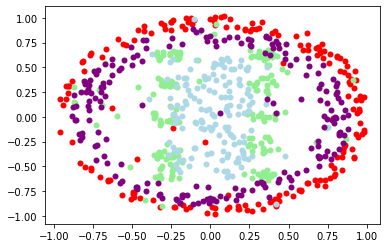

In [209]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

In [214]:
train_csv_url = 'https://raw.githubusercontent.com/nthu-datalab/ml/master/labs/08_CV_Ensembling/CV_playground_dataset/train.csv'
test_csv_url = 'https://raw.githubusercontent.com/nthu-datalab/ml/master/labs/08_CV_Ensembling/CV_playground_dataset/test.csv'

train_df = pd.read_csv(train_csv_url)
# train_df.head()

label_le = LabelEncoder()
train_df['Competitor'] = label_le.fit_transform(train_df['Competitor'].values)
x_train = (train_df.drop('Competitor', axis=1).values)
y_train = (train_df['Competitor'].values)
# print(y_train)

test_df = pd.read_csv(test_csv_url)
display(test_df.head())
test_df['Competitor'] = label_le.fit_transform(test_df['Competitor'].values)
x_test = (test_df.drop('Competitor', axis=1).values)
y_test = (test_df['Competitor'].values)


,YCord,XCord,Competitor
0,-0.608675,0.769448,Bob
1,-0.557823,0.502202,Sue
2,-0.657171,0.480321,Sue
3,-0.381579,-0.882649,Bob
4,0.643482,-0.663414,Bob


# LogisticRegression

In [240]:
lr_pipeline = Pipeline(
    steps=[
      ("scl", StandardScaler()),
      ('clf', LogisticRegression(C = 10, random_state = 0, solver = "liblinear"))
    ]
)

params_grid = {
    'clf__C': [1, 3, 5, 7, 10, 15, 20, 50, 100]   
}

grid = GridSearchCV(
    estimator = lr_pipeline, 
    param_grid = params_grid, 
    scoring = "accuracy", 
    cv = 3
)
grid.fit(x_train, y_train)

print("[LR_GS]")
print("Train Acc:", grid.score(x_train, y_train))
print("Test  Acc:", grid.score(x_test, y_test))
print("Best Param:", grid.best_params_)

[LR_GS]
Train Acc: 0.2859078590785908
Test  Acc: 0.2702702702702703
Best Param: {'clf__C': 1}


# DecisionTreeClassfier

In [238]:
dt_pipeline = Pipeline(
    steps=[
      ("scl", StandardScaler()),
      ('clf', DecisionTreeClassifier(max_depth = None, random_state = 0)) 
    ]
)

params_grid = {
    'clf__max_depth': [None, 1, 3, 5, 7, 8, 9, 10, 12, 15, 20]
}

grid = GridSearchCV(
    estimator = dt_pipeline, 
    param_grid = params_grid, 
    scoring = "accuracy", 
    cv = 3
)
grid.fit(x_train, y_train)

print("[DT_GS]")
print("Train Acc:", grid.score(x_train, y_train))
print("Test  Acc:", grid.score(x_test, y_test))
print("Best Param:", grid.best_params_)

[DT_GS]
Train Acc: 0.8929539295392954
Test  Acc: 0.7837837837837838
Best Param: {'clf__max_depth': 7}


# KNN

In [243]:
knn_pipeline = Pipeline(
    steps=[
      ("scl", StandardScaler()),
      ("clf", KNeighborsClassifier(n_neighbors = 10, p = 2, metric = "minkowski"))     
    ]

)

params_grid = {
    'clf__n_neighbors': [1, 3, 5, 7, 10, 12, 15, 20],
}

grid = GridSearchCV(
    estimator = knn_pipeline, 
    param_grid = params_grid, 
    scoring = "accuracy", 
    cv = 3
)
grid.fit(x_train, y_train)
knn_best_params_ = grid.best_params_

print("[KNN_GS]")
print("Train Acc:", grid.score(x_train, y_train))
print("Test  Acc:", grid.score(x_test, y_test))
print("Best Param:", grid.best_params_)

[KNN_GS]
Train Acc: 0.9065040650406504
Test  Acc: 0.7891891891891892
Best Param: {'clf__n_neighbors': 3}


# SVC

In [233]:
svc_pipeline = Pipeline(
    steps=[
      ("scl", StandardScaler()),
      ("clf", SVC(kernel='rbf', random_state=0, gamma=0.001, C=100.0))  
    ]
)

params_grid = {
    'clf__kernel': ['rbf'],
    'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'clf__C': [0.1, 1.0, 10.0, 100.0]
}

grid = GridSearchCV(
    estimator = svc_pipeline, 
    param_grid = params_grid, 
    scoring = "accuracy", 
    cv = 3
)
grid.fit(x_train, y_train)

print("[SVC_GS]")
print("Train Acc:", grid.score(x_train, y_train))
print("Test  Acc:", grid.score(x_test, y_test))
print("Best Param:", grid.best_params_)

[SVC_GS]
Train Acc: 0.8943089430894309
Test  Acc: 0.8486486486486486
Best Param: {'clf__C': 100.0, 'clf__gamma': 1.0, 'clf__kernel': 'rbf'}


# Voting

In [252]:

#pipe
dt_pipeline = Pipeline(
    steps=[
      ("scl", StandardScaler()),
      ('clf', DecisionTreeClassifier(max_depth = 7, random_state = 0)) 
    ]
)

knn_pipeline = Pipeline(
    steps=[
      ("scl", StandardScaler()),
      ("clf", KNeighborsClassifier(n_neighbors = 10, p = 2, metric = "minkowski"))     
    ]

)

svc_pipeline = Pipeline(
    steps=[
      ("scl", StandardScaler()),
      ("clf", SVC(kernel='rbf', random_state=0, gamma=0.001, C=100.0, probability=True))  
    ]
)

# pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C = 10, random_state = 0, solver = "liblinear")]])
# pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth = None, random_state = 0)]])
# pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 5)]])

#voting
clf_labels = ['DecisionTreeClassifier', 'KNeighborsClassifier', 'SVC']

best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))):
    clf = VotingClassifier(estimators=[('DecisionTreeClassifier', dt_pipeline), ('KNeighborsClassifier', knn_pipeline), ('SVC', svc_pipeline)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=10)
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print("[Voting]")
print('\nBest %s: %.3f' % (best_w, best_score))
voting = best_vt.fit(x_train, y_train)
y_train_pred = voting.predict(x_train)
y_test_pred = voting.predict(x_test)
voting_train = accuracy_score(y_train, y_train_pred) 
voting_test = accuracy_score(y_test, y_test_pred)
print("Train Acc:", voting_train)
print("Test  Acc:", voting_test)

(0, 1, 2): 0.786 (+/- 0.058)
(0, 2, 1): 0.801 (+/- 0.055)
(1, 0, 2): 0.797 (+/- 0.046)
(1, 2, 0): 0.818 (+/- 0.041)
(2, 0, 1): 0.791 (+/- 0.050)
(2, 1, 0): 0.804 (+/- 0.041)
[Voting]

Best (1, 2, 0): 0.818
Train Acc: 0.8970189701897019
Test  Acc: 0.7675675675675676


# Bagging


In [294]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.8, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

# Bagging
bag = bag.fit(x_train, y_train)
y_train_pred = bag.predict(x_train)
y_test_pred = bag.predict(x_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print("[Bagging]")
print("Train Acc:", bag_train)
print("Test  Acc:", bag_test)

[Bagging]
Train Acc: 1.0
Test  Acc: 0.8162162162162162


# Boosting - AdaBoost

In [293]:
# adaboost
ada_pipeline = Pipeline(
    steps = [
        ("clf", AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))     
    ]
)

# single decision tree
####################################################################
# Using base tree with decision stump(depth=1)
params_grid = {
    'clf__base_estimator__max_depth': [1],
    'clf__n_estimators': [1, 5, 10, 30, 50, 70, 90, 100, 200]
}
stump_grid = GridSearchCV(
    estimator = ada_pipeline, 
    param_grid = params_grid, 
    scoring = "accuracy", 
    cv = 5
)
stump_grid.fit(x_train, y_train)


y_train_pred = stump_grid.predict(x_train)
y_test_pred = stump_grid.predict(x_test)

stump_ada_train = accuracy_score(y_train, y_train_pred) 
stump_ada_test = accuracy_score(y_test, y_test_pred) 
print("[Adaboost_BaseTree_MaxDepth=1]")
print("Train Acc:", stump_ada_train)
print("Test  Acc:", stump_ada_test)
print(stump_grid.best_params_)


####################################################################
# Using base tree with decision stump(depth=best_depth)
params_grid = {
    'clf__base_estimator__max_depth': [5, 7, 9, 10, 20],
    'clf__n_estimators': [1, 10, 50, 100, 150, 200]
}

ada_grid = GridSearchCV(
    estimator = ada_pipeline, 
    param_grid = params_grid, 
    scoring = "accuracy",
    n_jobs = 2,
    cv = 5
)

ada_grid.fit(x_train, y_train)

y_train_pred = ada_grid.predict(x_train)
y_test_pred = ada_grid.predict(x_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print("[Adaboost_BaseTree_MaxDepth=Best]")
print("Train Acc:", ada_train)
print("Test  Acc:", ada_test)
print(ada_grid.best_params_)

[Adaboost_BaseTree_MaxDepth=1]
Train Acc: 0.6734417344173442
Test  Acc: 0.6
{'clf__base_estimator__max_depth': 1, 'clf__n_estimators': 100}
[Adaboost_BaseTree_MaxDepth=Best]
Train Acc: 1.0
Test  Acc: 0.8108108108108109
{'clf__base_estimator__max_depth': 10, 'clf__n_estimators': 200}


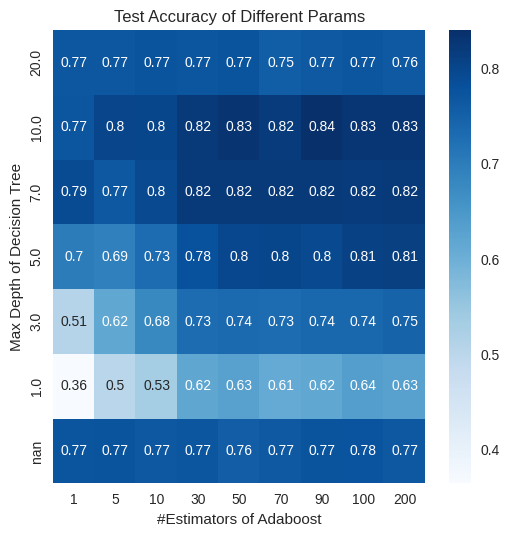

In [281]:
data = pd.DataFrame(ada_grid.cv_results_)
df = data.pivot(index='param_clf__base_estimator__max_depth', columns='param_clf__n_estimators', values='mean_test_score')
fig, ax = plt.subplots(dpi=300, figsize=(8, 8))
sns.heatmap(data=df, ax=ax, annot=True, cmap=plt.cm.Blues)
ax.set_title('Test Acc with Different Params')
ax.set_xlabel('#Estimators of Adaboost')
ax.set_ylabel('Max Depth of Decision Tree')
ax.invert_yaxis()
plt.show()

# Conclusion

According to the experiments mentioned before, we can observe that 

**Adaboost_BaseTree_MaxDepth=1** have test_acc **0.6** (DecisionTree_Depth = 1, Adaboost_Estimator = 100).

**Adaboost_BaseTree_MaxDepth=Best** show the best test_acc overall with **0.816216** (DecisionTree_Depth = 10, Adaboost_Estimator = 150).

But sometimes **Adaboost** performance is worse than **Bagging** ,not stable at all.